In [ ]:
# Install lightgbm if not available
# !pip install lightgbm

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import lightgbm as lgb
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping
import os
import warnings
warnings.filterwarnings('ignore')

os.environ['CUDA_VISIBLE_DEVICES'] = ''
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 6)

# Set random seeds for reproducibility
np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)

print("All libraries loaded successfully!")

All libraries loaded successfully!


## Step 1: Load and Preprocess Data

In [2]:
# Load data - Use monthdata1.csv (1 year of training data)
data_file = 'monthdata1.csv'
print(f"📅 Using training data from: {data_file}")

data = pd.read_csv(data_file, header=None, names=['datetime', 'load'])
data['datetime'] = pd.to_datetime(data['datetime'], format='%d/%m/%Y %H:%M')
data = data.set_index('datetime')

# Ensure we have complete days (288 samples per day = 24 hours × 12 intervals of 5 min)
total_samples = data.shape[0]
num_complete_days = total_samples // 288
samples_to_use = num_complete_days * 288

print(f"\n📊 Data Statistics:")
print(f"   Total samples: {total_samples:,}")
print(f"   Complete days: {num_complete_days}")
print(f"   Samples to use: {samples_to_use:,}")
print(f"   Date range: {data.index.min().strftime('%Y-%m-%d')} to {data.index.max().strftime('%Y-%m-%d')}")

data = data.iloc[:samples_to_use]
print(f"\n   Load range: {data['load'].min():.2f} - {data['load'].max():.2f} MW")
print(f"   Mean load: {data['load'].mean():.2f} MW")
data.head()

📅 Using training data from: monthdata1.csv

📊 Data Statistics:
   Total samples: 103,064
   Complete days: 357
   Samples to use: 102,816
   Date range: 2025-01-17 to 2026-01-16

   Load range: 1450.40 - 8419.34 MW
   Mean load: 4331.97 MW


,load
datetime,
2025-01-17 00:00:00,2586.69
2025-01-17 00:05:00,2517.80
2025-01-17 00:10:00,2487.75
2025-01-17 00:15:00,2460.82
2025-01-17 00:20:00,2425.10


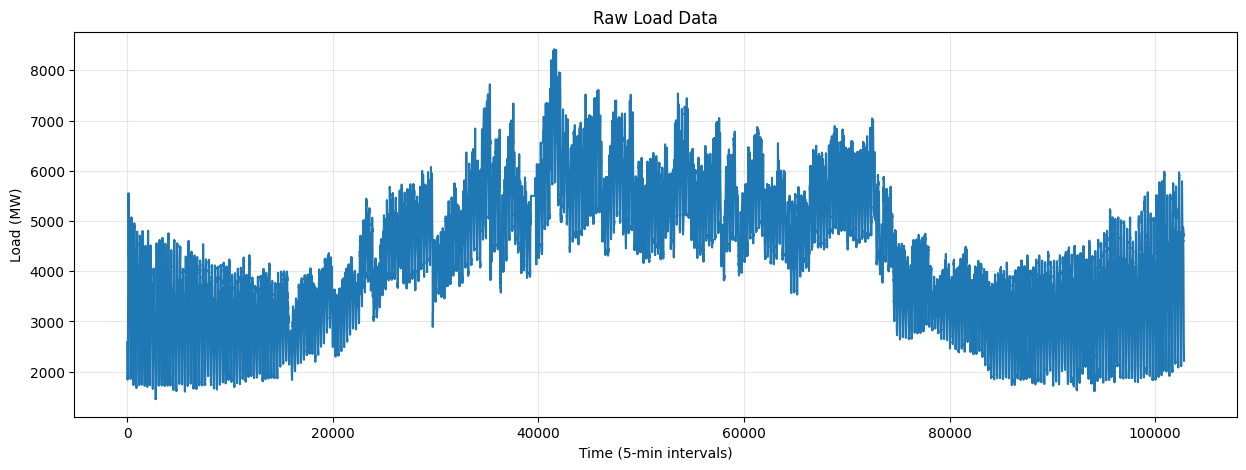

In [3]:
# Plot the raw data
plt.figure(figsize=(15, 5))
plt.plot(data['load'].values)
plt.title('Raw Load Data')
plt.xlabel('Time (5-min intervals)')
plt.ylabel('Load (MW)')
plt.grid(True, alpha=0.3)
plt.show()

## Step 2: Feature Engineering for LightGBM

In [4]:
def create_features(df):
    """
    Create time-based and lag features for LightGBM
    """
    df = df.copy()
    
    # Time-based features
    df['hour'] = df.index.hour
    df['minute'] = df.index.minute
    df['dayofweek'] = df.index.dayofweek
    df['dayofmonth'] = df.index.day
    df['month'] = df.index.month
    df['is_weekend'] = (df.index.dayofweek >= 5).astype(int)
    
    # Time slot of the day (0-287)
    df['time_slot'] = df['hour'] * 12 + df['minute'] // 5
    
    # Cyclical encoding for periodic features
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['day_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
    df['day_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)
    
    return df

def create_lag_features(df, lags=[1, 2, 3, 6, 12, 24, 288]):
    """
    Create lag features
    - 1, 2, 3: last 5, 10, 15 minutes
    - 6, 12, 24: 30 min, 1 hour, 2 hours ago
    - 288: same time yesterday
    """
    df = df.copy()
    
    for lag in lags:
        df[f'lag_{lag}'] = df['load'].shift(lag)
    
    # Rolling statistics
    df['rolling_mean_12'] = df['load'].shift(1).rolling(window=12).mean()  # 1 hour mean
    df['rolling_std_12'] = df['load'].shift(1).rolling(window=12).std()    # 1 hour std
    df['rolling_mean_288'] = df['load'].shift(1).rolling(window=288).mean()  # 1 day mean
    
    # Difference features
    df['diff_1'] = df['load'].diff(1)
    df['diff_288'] = df['load'].diff(288)  # Day-over-day difference
    
    return df

# Apply feature engineering
data_featured = create_features(data)
data_featured = create_lag_features(data_featured)

# Drop NaN values created by lag features
data_featured = data_featured.dropna()

print(f"Features created: {data_featured.shape[1] - 1}")
print(f"Samples after removing NaN: {data_featured.shape[0]}")
data_featured.head()

Features created: 23
Samples after removing NaN: 102528


,load,hour,minute,dayofweek,dayofmonth,month,is_weekend,time_slot,hour_sin,hour_cos,...,lag_3,lag_6,lag_12,lag_24,lag_288,rolling_mean_12,rolling_std_12,rolling_mean_288,diff_1,diff_288
datetime,,,,,,,,,,,,,,,,,,,,,
2025-01-18 00:10:00,2568.96,0,10,5,18,1,1,2,0.0,1.0,...,2845.30,2976.91,3287.73,3812.07,2586.69,2981.066667,213.820309,3799.071979,-31.56,-17.73
2025-01-18 00:15:00,2520.13,0,15,5,18,1,1,3,0.0,1.0,...,2668.62,2905.45,3234.51,3750.51,2517.80,2921.169167,220.669920,3799.010417,-48.83,2.33
2025-01-18 00:20:00,2491.41,0,20,5,18,1,1,4,0.0,1.0,...,2600.52,2873.66,3174.89,3717.21,2487.75,2861.637500,224.776465,3799.018507,-28.72,3.66
2025-01-18 00:25:00,2457.45,0,25,5,18,1,1,5,0.0,1.0,...,2568.96,2845.30,3121.05,3674.31,2460.82,2804.680833,224.778999,3799.031215,-33.96,-3.37
2025-01-18 00:30:00,2413.67,0,30,5,18,1,1,6,0.0,1.0,...,2520.13,2668.62,3072.77,3652.58,2425.10,2749.380833,221.475282,3799.019514,-43.78,-11.43


## Step 3: Train/Validation/Test Split

In [5]:
# Define features and target
feature_cols = [col for col in data_featured.columns if col != 'load']
X = data_featured[feature_cols].values
y = data_featured['load'].values

# Time-based split: 70% train, 15% validation, 15% test
train_size = int(len(X) * 0.70)
val_size = int(len(X) * 0.15)

X_train = X[:train_size]
y_train = y[:train_size]

X_val = X[train_size:train_size + val_size]
y_val = y[train_size:train_size + val_size]

X_test = X[train_size + val_size:]
y_test = y[train_size + val_size:]

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")

Training samples: 71769
Validation samples: 15379
Test samples: 15380


## Step 4: Train LightGBM Model

In [6]:
# Create LightGBM datasets
lgb_train = lgb.Dataset(X_train, label=y_train, feature_name=feature_cols)
lgb_val = lgb.Dataset(X_val, label=y_val, feature_name=feature_cols, reference=lgb_train)

# LightGBM hyperparameters
lgb_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'seed': 42
}

# Train LightGBM model
print("Training LightGBM model...")
lgb_model = lgb.train(
    lgb_params,
    lgb_train,
    num_boost_round=1000,
    valid_sets=[lgb_train, lgb_val],
    valid_names=['train', 'valid'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=100)
    ]
)

print(f"\nBest iteration: {lgb_model.best_iteration}")

Training LightGBM model...
Training until validation scores don't improve for 50 rounds
[100]	train's rmse: 20.7219	valid's rmse: 14.9194
[200]	train's rmse: 14.138	valid's rmse: 12.2253
[300]	train's rmse: 12.5797	valid's rmse: 12.1121
Early stopping, best iteration is:
[343]	train's rmse: 12.1279	valid's rmse: 11.9748

Best iteration: 343


<Figure size 1200x800 with 0 Axes>

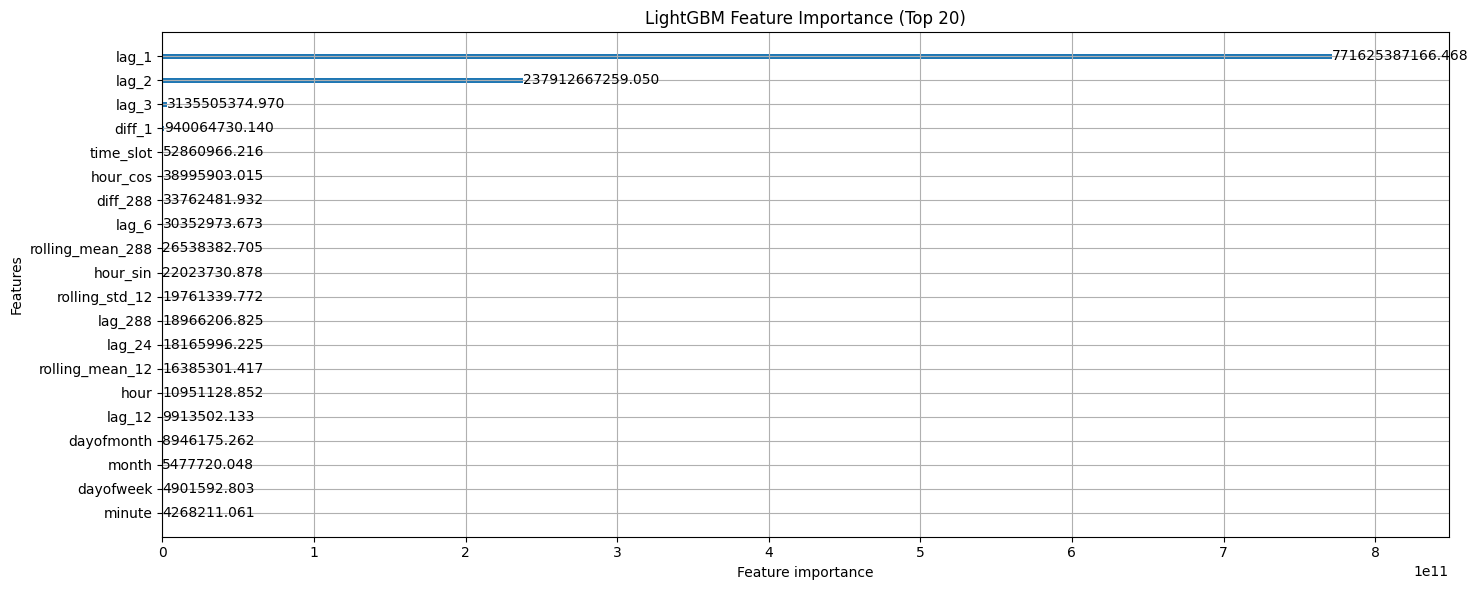

In [7]:
# Feature importance
plt.figure(figsize=(12, 8))
lgb.plot_importance(lgb_model, max_num_features=20, importance_type='gain')
plt.title('LightGBM Feature Importance (Top 20)')
plt.tight_layout()
plt.show()

In [8]:
# Get LightGBM predictions
lgb_pred_train = lgb_model.predict(X_train, num_iteration=lgb_model.best_iteration)
lgb_pred_val = lgb_model.predict(X_val, num_iteration=lgb_model.best_iteration)
lgb_pred_test = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)

# Calculate residuals (what LightGBM couldn't capture)
residuals_train = y_train - lgb_pred_train
residuals_val = y_val - lgb_pred_val
residuals_test = y_test - lgb_pred_test

# LightGBM standalone metrics
lgb_rmse_train = np.sqrt(mean_squared_error(y_train, lgb_pred_train))
lgb_rmse_val = np.sqrt(mean_squared_error(y_val, lgb_pred_val))
lgb_rmse_test = np.sqrt(mean_squared_error(y_test, lgb_pred_test))
lgb_mape_test = mean_absolute_percentage_error(y_test, lgb_pred_test) * 100

print("\n=== LightGBM Standalone Results ===")
print(f"Train RMSE: {lgb_rmse_train:.2f} MW")
print(f"Validation RMSE: {lgb_rmse_val:.2f} MW")
print(f"Test RMSE: {lgb_rmse_test:.2f} MW")
print(f"Test MAPE: {lgb_mape_test:.2f}%")


=== LightGBM Standalone Results ===
Train RMSE: 12.13 MW
Validation RMSE: 11.97 MW
Test RMSE: 20.96 MW
Test MAPE: 0.36%


## Step 5: Prepare Residuals for LSTM

In [9]:
# Scale residuals for LSTM
residual_scaler = MinMaxScaler(feature_range=(-1, 1))
residuals_train_scaled = residual_scaler.fit_transform(residuals_train.reshape(-1, 1))
residuals_val_scaled = residual_scaler.transform(residuals_val.reshape(-1, 1))
residuals_test_scaled = residual_scaler.transform(residuals_test.reshape(-1, 1))

def create_lstm_sequences(data, nlags):
    """
    Create sequences for LSTM: X = last nlags values, y = next value
    """
    X, y = [], []
    for i in range(nlags, len(data)):
        X.append(data[i-nlags:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Set number of time steps for LSTM
nlags = 24  # 2 hours of history (24 × 5 min)

# Create sequences for training
lstm_X_train, lstm_y_train = create_lstm_sequences(residuals_train_scaled, nlags)
lstm_X_val, lstm_y_val = create_lstm_sequences(residuals_val_scaled, nlags)
lstm_X_test, lstm_y_test = create_lstm_sequences(residuals_test_scaled, nlags)

# Reshape for LSTM: (samples, timesteps, features)
lstm_X_train = lstm_X_train.reshape(lstm_X_train.shape[0], nlags, 1)
lstm_X_val = lstm_X_val.reshape(lstm_X_val.shape[0], nlags, 1)
lstm_X_test = lstm_X_test.reshape(lstm_X_test.shape[0], nlags, 1)

print(f"LSTM Training samples: {lstm_X_train.shape[0]}")
print(f"LSTM Validation samples: {lstm_X_val.shape[0]}")
print(f"LSTM Test samples: {lstm_X_test.shape[0]}")
print(f"LSTM Input shape: {lstm_X_train.shape}")

LSTM Training samples: 71745
LSTM Validation samples: 15355
LSTM Test samples: 15356
LSTM Input shape: (71745, 24, 1)


## Step 6: Build and Train LSTM Model for Residuals

In [10]:
# Build LSTM model
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(64, input_shape=input_shape, return_sequences=True),
        Dropout(0.2),
        LSTM(32, return_sequences=False),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    model.compile(loss='mse', optimizer='adam')
    return model

lstm_model = build_lstm_model((nlags, 1))
lstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,857 (116.63 KB)

 Trainable params: 29,857 (116.63 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Train LSTM model
print("\nTraining LSTM model on residuals...")

es = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

history = lstm_model.fit(
    lstm_X_train, lstm_y_train,
    epochs=100,
    batch_size=64,
    validation_data=(lstm_X_val, lstm_y_val),
    callbacks=[es],
    verbose=1
)


Training LSTM model on residuals...
Epoch 1/100
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 32s 24ms/step - loss: 2.1972e-04 - val_loss: 2.1170e-04
Epoch 2/100
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - loss: 2.1544e-04 - val_loss: 2.1038e-04
Epoch 3/100
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - loss: 2.1524e-04 - val_loss: 2.0999e-04
Epoch 4/100
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - loss: 2.1460e-04 - val_loss: 2.0910e-04
Epoch 5/100
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 41s 24ms/step - loss: 2.1327e-04 - val_loss: 2.0965e-04
Epoch 6/100
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - loss: 2.1068e-04 - val_loss: 2.0833e-04
Epoch 7/100
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - loss: 2.0944e-04 - val_loss: 2.0902e-04
Epoch 8/100
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - loss: 2.0852e-04 - val_loss: 2.0972e-04
Epoch 9/100
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - loss: 2.0902e-04 - val_loss: 2.0772e-04
Epoch 10/100
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - loss: 2.0845

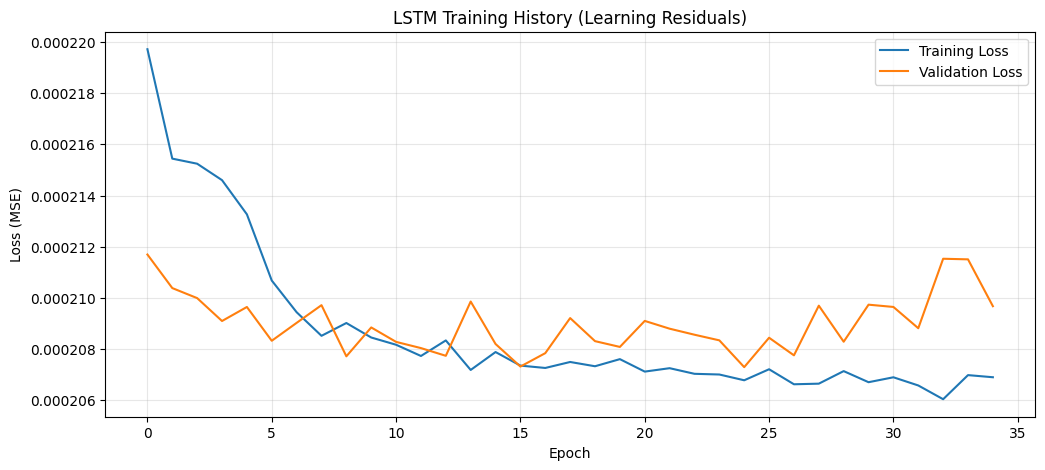

In [12]:
# Plot training history
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('LSTM Training History (Learning Residuals)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Step 7: Combine Predictions (Hybrid Model)

In [13]:
# Get LSTM predictions on residuals
lstm_pred_train = lstm_model.predict(lstm_X_train, verbose=0)
lstm_pred_val = lstm_model.predict(lstm_X_val, verbose=0)
lstm_pred_test = lstm_model.predict(lstm_X_test, verbose=0)

# Inverse transform LSTM predictions
lstm_pred_train_inv = residual_scaler.inverse_transform(lstm_pred_train).flatten()
lstm_pred_val_inv = residual_scaler.inverse_transform(lstm_pred_val).flatten()
lstm_pred_test_inv = residual_scaler.inverse_transform(lstm_pred_test).flatten()

# Align predictions (LSTM has nlags fewer predictions due to sequence creation)
lgb_pred_train_aligned = lgb_pred_train[nlags:]
lgb_pred_val_aligned = lgb_pred_val[nlags:]
lgb_pred_test_aligned = lgb_pred_test[nlags:]

y_train_aligned = y_train[nlags:]
y_val_aligned = y_val[nlags:]
y_test_aligned = y_test[nlags:]

# Combine: Hybrid = LightGBM + LSTM residual correction
hybrid_pred_train = lgb_pred_train_aligned + lstm_pred_train_inv
hybrid_pred_val = lgb_pred_val_aligned + lstm_pred_val_inv
hybrid_pred_test = lgb_pred_test_aligned + lstm_pred_test_inv

print(f"Aligned samples - Train: {len(y_train_aligned)}, Val: {len(y_val_aligned)}, Test: {len(y_test_aligned)}")

Aligned samples - Train: 71745, Val: 15355, Test: 15356


## Step 8: Evaluate Hybrid Model

In [14]:
# Calculate metrics
def calculate_metrics(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    mae = np.mean(np.abs(y_true - y_pred))
    print(f"{model_name}:")
    print(f"  RMSE: {rmse:.2f} MW")
    print(f"  MAPE: {mape:.2f}%")
    print(f"  MAE:  {mae:.2f} MW")
    return rmse, mape, mae

print("\n" + "="*50)
print("FINAL MODEL COMPARISON ON TEST SET")
print("="*50)

print("\n--- LightGBM Only ---")
lgb_metrics = calculate_metrics(y_test_aligned, lgb_pred_test_aligned, "LightGBM")

print("\n--- Hybrid (LightGBM + LSTM) ---")
hybrid_metrics = calculate_metrics(y_test_aligned, hybrid_pred_test, "Hybrid")

# Improvement
rmse_improvement = ((lgb_metrics[0] - hybrid_metrics[0]) / lgb_metrics[0]) * 100
mape_improvement = ((lgb_metrics[1] - hybrid_metrics[1]) / lgb_metrics[1]) * 100

print(f"\n--- Improvement from Hybrid ---")
print(f"  RMSE Improvement: {rmse_improvement:.2f}%")
print(f"  MAPE Improvement: {mape_improvement:.2f}%")


FINAL MODEL COMPARISON ON TEST SET

--- LightGBM Only ---
LightGBM:
  RMSE: 20.97 MW
  MAPE: 0.36%
  MAE:  10.73 MW

--- Hybrid (LightGBM + LSTM) ---
Hybrid:
  RMSE: 20.37 MW
  MAPE: 0.34%
  MAE:  10.37 MW

--- Improvement from Hybrid ---
  RMSE Improvement: 2.84%
  MAPE Improvement: 3.62%


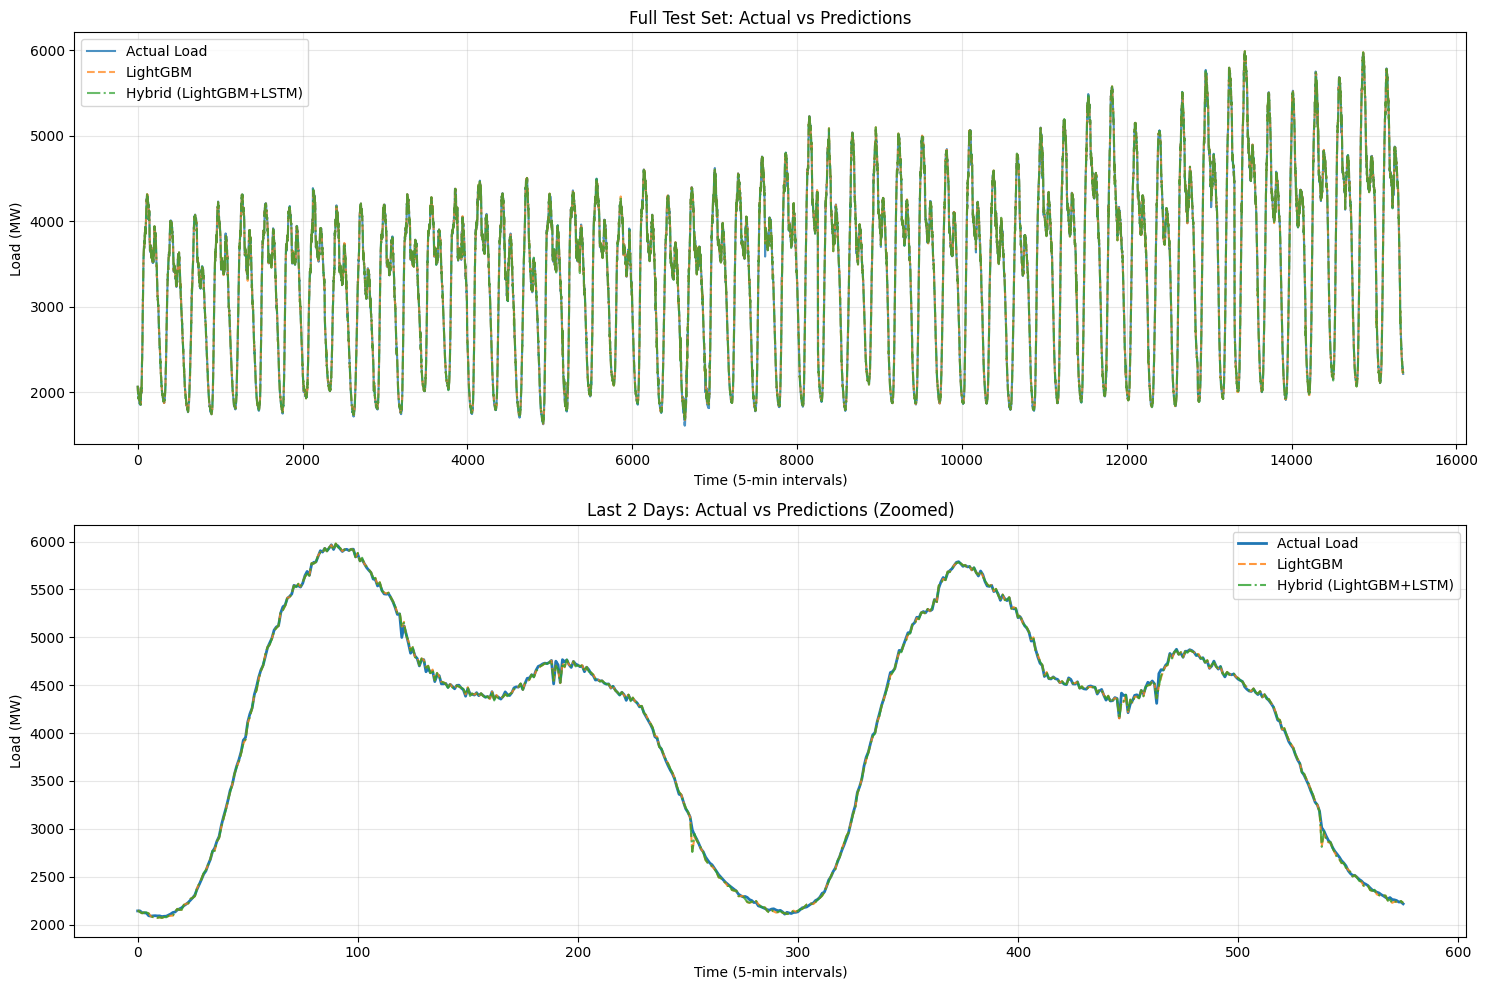

In [15]:
# Visualize predictions
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Full test set comparison
ax1 = axes[0]
ax1.plot(y_test_aligned, label='Actual Load', alpha=0.8)
ax1.plot(lgb_pred_test_aligned, label='LightGBM', alpha=0.7, linestyle='--')
ax1.plot(hybrid_pred_test, label='Hybrid (LightGBM+LSTM)', alpha=0.7, linestyle='-.')
ax1.set_xlabel('Time (5-min intervals)')
ax1.set_ylabel('Load (MW)')
ax1.set_title('Full Test Set: Actual vs Predictions')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Zoom into last 2 days (576 intervals)
ax2 = axes[1]
zoom = 576  # 2 days
ax2.plot(y_test_aligned[-zoom:], label='Actual Load', linewidth=2)
ax2.plot(lgb_pred_test_aligned[-zoom:], label='LightGBM', alpha=0.8, linestyle='--')
ax2.plot(hybrid_pred_test[-zoom:], label='Hybrid (LightGBM+LSTM)', alpha=0.8, linestyle='-.')
ax2.set_xlabel('Time (5-min intervals)')
ax2.set_ylabel('Load (MW)')
ax2.set_title('Last 2 Days: Actual vs Predictions (Zoomed)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

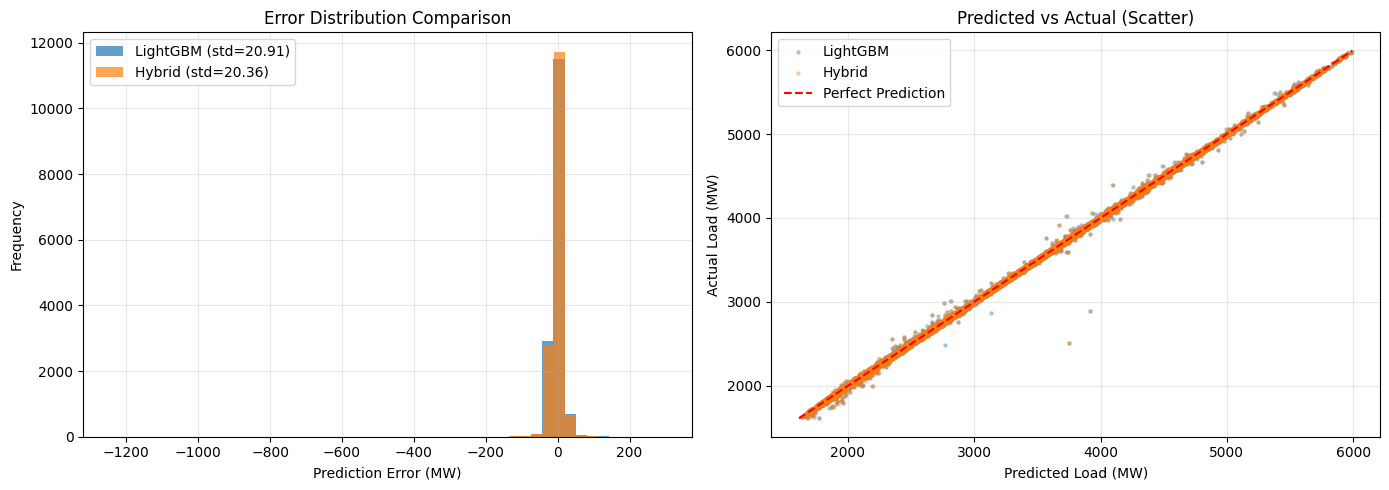

In [16]:
# Error distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

lgb_errors = y_test_aligned - lgb_pred_test_aligned
hybrid_errors = y_test_aligned - hybrid_pred_test

ax1 = axes[0]
ax1.hist(lgb_errors, bins=50, alpha=0.7, label=f'LightGBM (std={np.std(lgb_errors):.2f})')
ax1.hist(hybrid_errors, bins=50, alpha=0.7, label=f'Hybrid (std={np.std(hybrid_errors):.2f})')
ax1.set_xlabel('Prediction Error (MW)')
ax1.set_ylabel('Frequency')
ax1.set_title('Error Distribution Comparison')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2 = axes[1]
ax2.scatter(lgb_pred_test_aligned, y_test_aligned, alpha=0.3, s=5, label='LightGBM')
ax2.scatter(hybrid_pred_test, y_test_aligned, alpha=0.3, s=5, label='Hybrid')
max_val = max(y_test_aligned.max(), hybrid_pred_test.max())
min_val = min(y_test_aligned.min(), hybrid_pred_test.min())
ax2.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction')
ax2.set_xlabel('Predicted Load (MW)')
ax2.set_ylabel('Actual Load (MW)')
ax2.set_title('Predicted vs Actual (Scatter)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Step 9: Model Summary and Conclusions

In [17]:
# Summary table
print("\n" + "="*60)
print("          HYBRID LightGBM + LSTM MODEL SUMMARY")
print("="*60)
print(f"\nData Information:")
print(f"  Total samples used: {len(data_featured)}")
print(f"  Number of features: {len(feature_cols)}")
print(f"  LSTM sequence length: {nlags} time steps")

print(f"\nLightGBM Configuration:")
print(f"  Best iterations: {lgb_model.best_iteration}")
print(f"  Num leaves: {lgb_params['num_leaves']}")
print(f"  Learning rate: {lgb_params['learning_rate']}")

print(f"\nLSTM Configuration:")
print(f"  Architecture: LSTM(64) -> LSTM(32) -> Dense(16) -> Dense(1)")
print(f"  Dropout: 0.2")
print(f"  Optimizer: Adam")

print(f"\n" + "-"*60)
print(f"FINAL TEST RESULTS:")
print(f"-"*60)
print(f"  {'Model':<25} {'RMSE (MW)':<15} {'MAPE (%)':<15}")
print(f"  {'-'*55}")
print(f"  {'LightGBM Only':<25} {lgb_metrics[0]:<15.2f} {lgb_metrics[1]:<15.2f}")
print(f"  {'Hybrid (LightGBM+LSTM)':<25} {hybrid_metrics[0]:<15.2f} {hybrid_metrics[1]:<15.2f}")
print(f"  {'-'*55}")
print(f"  {'Improvement':<25} {rmse_improvement:>14.2f}% {mape_improvement:>14.2f}%")
print("="*60)


          HYBRID LightGBM + LSTM MODEL SUMMARY

Data Information:
  Total samples used: 102528
  Number of features: 23
  LSTM sequence length: 24 time steps

LightGBM Configuration:
  Best iterations: 343
  Num leaves: 31
  Learning rate: 0.05

LSTM Configuration:
  Architecture: LSTM(64) -> LSTM(32) -> Dense(16) -> Dense(1)
  Dropout: 0.2
  Optimizer: Adam

------------------------------------------------------------
FINAL TEST RESULTS:
------------------------------------------------------------
  Model                     RMSE (MW)       MAPE (%)       
  -------------------------------------------------------
  LightGBM Only             20.97           0.36           
  Hybrid (LightGBM+LSTM)    20.37           0.34           
  -------------------------------------------------------
  Improvement                         2.84%           3.62%


In [18]:
# Save models (optional)
# lgb_model.save_model('lightgbm_model.txt')
# lstm_model.save('lstm_residual_model.keras')
print("\nHybrid LightGBM + LSTM model training complete!")


Hybrid LightGBM + LSTM model training complete!


## Step 10: Predict Future Date Load

In [19]:
def predict_future_date(target_date_str, data_df, lgb_model, lstm_model, residual_scaler, feature_cols, nlags):
    """
    Predict load for a specific future date (24 hours = 288 intervals)
    
    Parameters:
    - target_date_str: Target date in format 'DD/MM/YYYY' or 'YYYY-MM-DD'
    - data_df: Training data DataFrame
    - lgb_model: Trained LightGBM model
    - lstm_model: Trained LSTM model
    - residual_scaler: Fitted scaler for residuals
    - feature_cols: List of feature column names
    - nlags: Number of lags for LSTM
    
    Returns:
    - DataFrame with predictions for the target date
    """
    from datetime import datetime, timedelta
    
    # Parse target date
    try:
        target_date = pd.to_datetime(target_date_str, format='%d/%m/%Y')
    except:
        target_date = pd.to_datetime(target_date_str)
    
    # Start from midnight of target date
    prediction_start = target_date.replace(hour=0, minute=0, second=0)
    
    last_data_date = data_df.index[-1]
    days_ahead = (prediction_start - last_data_date).days
    
    print(f"{'='*60}")
    print(f"🔮 PREDICTING LOAD FOR: {target_date.strftime('%A, %B %d, %Y')}")
    print(f"{'='*60}")
    print(f"Last available data: {last_data_date.strftime('%Y-%m-%d %H:%M')}")
    print(f"Days ahead: {days_ahead}")
    print(f"{'='*60}")
    
    # Initialize with historical patterns
    # Use same day of week from training data for better accuracy
    target_dow = target_date.dayofweek
    
    # Find similar days in training data (same day of week)
    similar_days = data_df[data_df.index.dayofweek == target_dow]
    if len(similar_days) > 0:
        # Use average pattern from similar days
        daily_pattern = similar_days.groupby(similar_days.index.time)['load'].mean()
    else:
        daily_pattern = data_df.groupby(data_df.index.time)['load'].mean()
    
    # Store predictions
    predictions = []
    timestamps = []
    
    # Use last known residuals for LSTM
    residual_history = list(residuals_test[-nlags:]) if 'residuals_test' in dir() else [0] * nlags
    
    # Get recent load values for lag features
    recent_loads = list(data_df['load'].values[-576:])  # Last 2 days
    
    # Predict 288 intervals (24 hours)
    for i in range(288):
        current_time = prediction_start + timedelta(minutes=5 * i)
        timestamps.append(current_time)
        
        # Create features
        temp_df = pd.DataFrame(index=[current_time])
        
        # Time features
        temp_df['hour'] = current_time.hour
        temp_df['minute'] = current_time.minute
        temp_df['dayofweek'] = current_time.dayofweek
        temp_df['dayofmonth'] = current_time.day
        temp_df['month'] = current_time.month
        temp_df['is_weekend'] = int(current_time.dayofweek >= 5)
        temp_df['time_slot'] = current_time.hour * 12 + current_time.minute // 5
        
        # Cyclical features
        temp_df['hour_sin'] = np.sin(2 * np.pi * current_time.hour / 24)
        temp_df['hour_cos'] = np.cos(2 * np.pi * current_time.hour / 24)
        temp_df['day_sin'] = np.sin(2 * np.pi * current_time.dayofweek / 7)
        temp_df['day_cos'] = np.cos(2 * np.pi * current_time.dayofweek / 7)
        
        # Lag features - use historical pattern + predictions
        all_loads = recent_loads + predictions
        for lag in [1, 2, 3, 6, 12, 24, 288]:
            if len(all_loads) >= lag:
                temp_df[f'lag_{lag}'] = all_loads[-lag]
            else:
                # Use historical pattern for missing lags
                time_key = current_time.time()
                temp_df[f'lag_{lag}'] = daily_pattern.get(time_key, data_df['load'].mean())
        
        # Rolling features
        temp_df['rolling_mean_12'] = np.mean(all_loads[-12:]) if len(all_loads) >= 12 else data_df['load'].mean()
        temp_df['rolling_std_12'] = np.std(all_loads[-12:]) if len(all_loads) >= 12 else 0
        temp_df['rolling_mean_288'] = np.mean(all_loads[-288:]) if len(all_loads) >= 288 else data_df['load'].mean()
        
        # Difference features
        temp_df['diff_1'] = all_loads[-1] - all_loads[-2] if len(all_loads) >= 2 else 0
        temp_df['diff_288'] = all_loads[-1] - all_loads[-288] if len(all_loads) >= 288 else 0
        
        # Prepare feature vector (ensure correct order)
        X_pred = temp_df[feature_cols].values
        
        # LightGBM prediction
        lgb_pred = lgb_model.predict(X_pred, num_iteration=lgb_model.best_iteration)[0]
        
        # LSTM residual correction
        lstm_input = np.array(residual_history[-nlags:]).reshape(1, nlags, 1)
        lstm_input_scaled = residual_scaler.transform(lstm_input.reshape(-1, 1)).reshape(1, nlags, 1)
        lstm_pred_scaled = lstm_model.predict(lstm_input_scaled, verbose=0)
        lstm_pred = residual_scaler.inverse_transform(lstm_pred_scaled)[0, 0]
        
        # Hybrid prediction
        hybrid_pred = lgb_pred + lstm_pred
        predictions.append(hybrid_pred)
        
        # Update histories
        residual_history.append(lstm_pred)
        recent_loads.append(hybrid_pred)
    
    # Create forecast DataFrame
    forecast_df = pd.DataFrame({
        'datetime': timestamps,
        'predicted_load': predictions
    })
    forecast_df.set_index('datetime', inplace=True)
    
    return forecast_df


# ============================================================
# SET YOUR TARGET DATE HERE
# ============================================================
TARGET_DATE = "18/01/2026"  # Format: DD/MM/YYYY
# ============================================================

# Run prediction
forecast = predict_future_date(
    TARGET_DATE,
    data_featured,
    lgb_model,
    lstm_model,
    residual_scaler,
    feature_cols,
    nlags
)

print(f"\n✅ Predictions generated for {TARGET_DATE}")
print(f"\n📊 Load Summary:")
print(f"   Min Load:  {forecast['predicted_load'].min():.2f} MW")
print(f"   Max Load:  {forecast['predicted_load'].max():.2f} MW")
print(f"   Mean Load: {forecast['predicted_load'].mean():.2f} MW")

🔮 PREDICTING LOAD FOR: Sunday, January 18, 2026
Last available data: 2026-01-16 03:05
Days ahead: 1

✅ Predictions generated for 18/01/2026

📊 Load Summary:
   Min Load:  1557.28 MW
   Max Load:  2492.39 MW
   Mean Load: 2187.85 MW


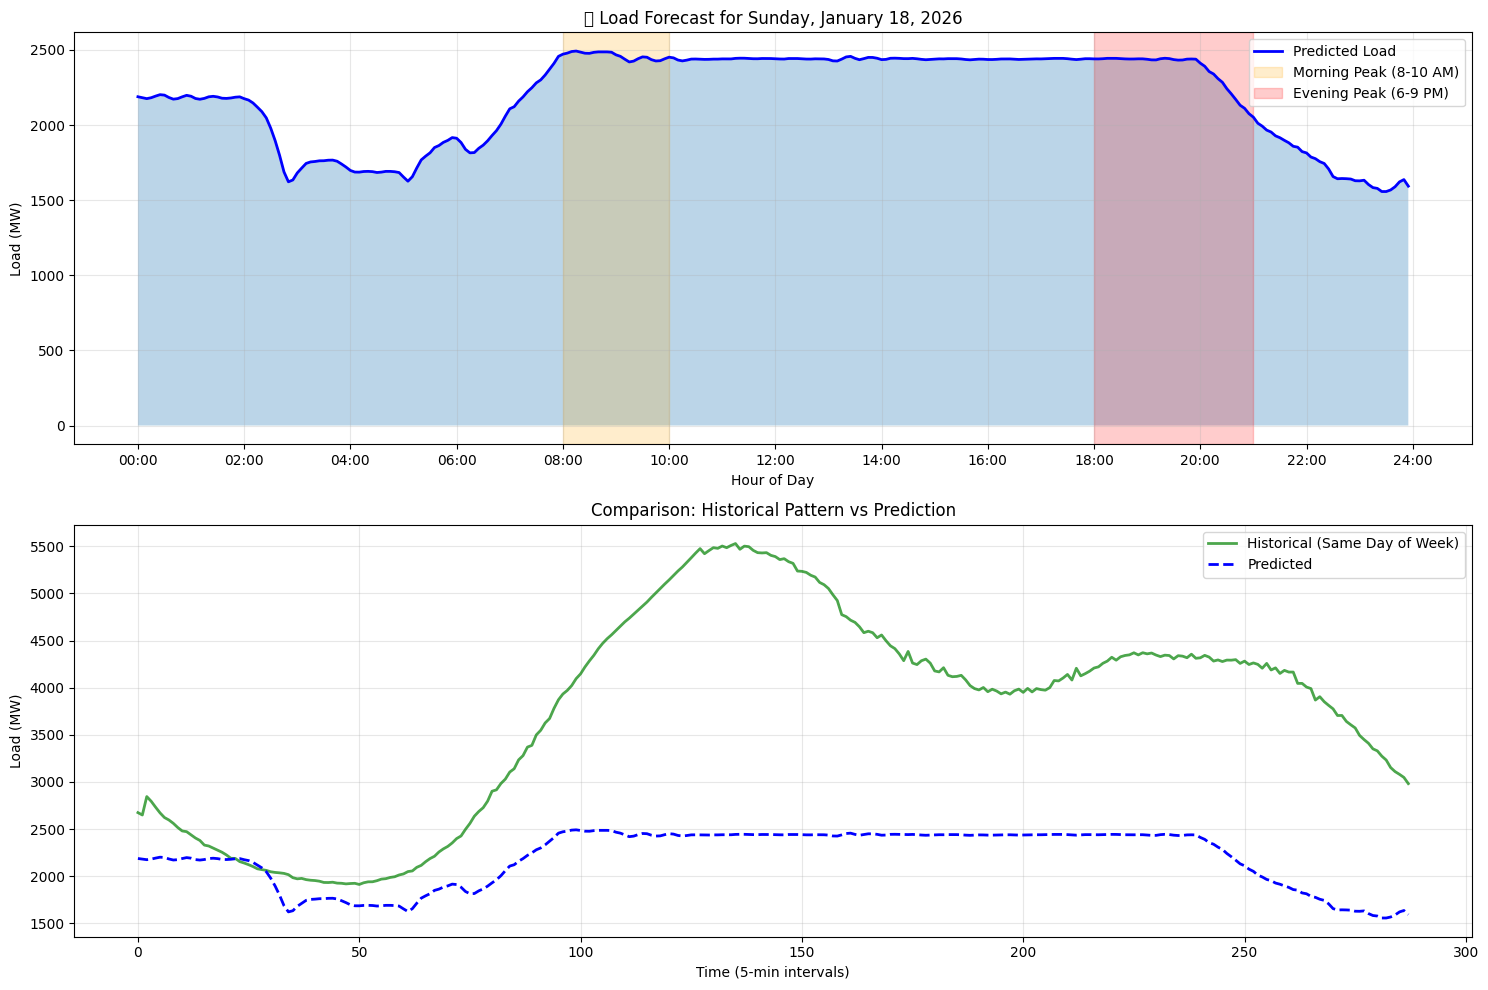

In [20]:
# Visualize the forecast
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Plot 1: Full day forecast
ax1 = axes[0]
hours = [t.hour + t.minute/60 for t in forecast.index]
ax1.plot(hours, forecast['predicted_load'].values, 'b-', linewidth=2, label='Predicted Load')
ax1.fill_between(hours, forecast['predicted_load'].values, alpha=0.3)
ax1.axvspan(8, 10, alpha=0.2, color='orange', label='Morning Peak (8-10 AM)')
ax1.axvspan(18, 21, alpha=0.2, color='red', label='Evening Peak (6-9 PM)')
ax1.set_xlabel('Hour of Day')
ax1.set_ylabel('Load (MW)')
ax1.set_title(f"🔮 Load Forecast for {forecast.index[0].strftime('%A, %B %d, %Y')}")
ax1.set_xticks(range(0, 25, 2))
ax1.set_xticklabels([f'{h:02d}:00' for h in range(0, 25, 2)])
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Compare with historical same day of week
ax2 = axes[1]
target_dow = forecast.index[0].dayofweek
historical_same_dow = data_featured[data_featured.index.dayofweek == target_dow]

if len(historical_same_dow) >= 288:
    # Get last occurrence of same day of week
    last_same_dow_data = historical_same_dow['load'].values[-288:]
    ax2.plot(range(288), last_same_dow_data, 'g-', linewidth=2, alpha=0.7, 
             label=f'Historical (Same Day of Week)')
ax2.plot(range(288), forecast['predicted_load'].values, 'b--', linewidth=2, 
         label='Predicted')
ax2.set_xlabel('Time (5-min intervals)')
ax2.set_ylabel('Load (MW)')
ax2.set_title('Comparison: Historical Pattern vs Prediction')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [21]:
# Hourly summary table
print("="*70)
print(f"📊 HOURLY LOAD FORECAST FOR {forecast.index[0].strftime('%B %d, %Y')}")
print("="*70)
print(f"\n{'Hour':<10} {'Predicted Load (MW)':<20} {'Status':<20}")
print("-"*55)

for hour in range(24):
    hour_data = forecast[forecast.index.hour == hour]['predicted_load']
    avg_load = hour_data.mean()
    
    if 8 <= hour <= 10:
        status = "🌅 Morning Peak"
    elif 18 <= hour <= 21:
        status = "🌆 Evening Peak"
    elif 0 <= hour <= 5:
        status = "🌙 Night (Low)"
    else:
        status = "☀️ Regular"
    
    print(f"{hour:02d}:00     {avg_load:<20.2f} {status}")

peak_time = forecast['predicted_load'].idxmax()
min_time = forecast['predicted_load'].idxmin()

print("\n" + "="*70)
print("🎯 KEY INSIGHTS:")
print("="*70)
print(f"  ⚡ Peak Load:    {forecast['predicted_load'].max():.2f} MW at {peak_time.strftime('%H:%M')}")
print(f"  📉 Minimum Load: {forecast['predicted_load'].min():.2f} MW at {min_time.strftime('%H:%M')}")
print(f"  📊 Average Load: {forecast['predicted_load'].mean():.2f} MW")
print(f"  📈 Load Range:   {forecast['predicted_load'].max() - forecast['predicted_load'].min():.2f} MW")
print("="*70)

# Save to CSV
output_filename = f"forecast_{forecast.index[0].strftime('%Y%m%d')}.csv"
forecast.to_csv(output_filename)
print(f"\n✅ Forecast saved to: {output_filename}")

📊 HOURLY LOAD FORECAST FOR January 18, 2026

Hour       Predicted Load (MW)  Status              
-------------------------------------------------------
00:00     2186.57              🌙 Night (Low)
01:00     2182.66              🌙 Night (Low)
02:00     1946.87              🌙 Night (Low)
03:00     1743.96              🌙 Night (Low)
04:00     1689.13              🌙 Night (Low)
05:00     1786.55              🌙 Night (Low)
06:00     1902.39              ☀️ Regular
07:00     2266.64              ☀️ Regular
08:00     2483.43              🌅 Morning Peak
09:00     2440.39              🌅 Morning Peak
10:00     2438.21              🌅 Morning Peak
11:00     2442.28              ☀️ Regular
12:00     2440.65              ☀️ Regular
13:00     2441.99              ☀️ Regular
14:00     2440.24              ☀️ Regular
15:00     2438.93              ☀️ Regular
16:00     2438.22              ☀️ Regular
17:00     2440.98              ☀️ Regular
18:00     2441.27              🌆 Evening Peak
19:00     2437